# Decision trees 

Decision trees are supervised learning models that map features to a target via axis aligned splits. A tree recursively partitions the predictor space into regions and assigns a constant prediction in each terminal region. Trees handle mixed numeric and categorical features, scale to moderately large data, and are easy to visualize.

## CART

- **Classification trees** predict a categorical response. At each node, a split is chosen to improve class purity using an impurity measure such as Gini or entropy
- **Regression trees** predict a numeric response at each node, a split is chosen to reduce squared error.

## Impurity and split criteria

For a node with class proportions $p_1, p_2, \dots, p_K$:

- **Gini**: $G = 1 - \sum_{k=1}^{K} p_k^2$
- **Entropy**: $H = -\sum_{k=1}^{K} p_k \log_2 p_k$

A candidate split partitions a node into children with sizes $n_L$ and $n_R$. The information gain using entropy is
$$
IG = H_{\text{parent}} - \left(\frac{n_L}{n_L + n_R} H_L + \frac{n_R}{n_L + n_R} H_R\right).
$$

For regression, splits minimize the residual sum of squares
$$
RSS = \sum_{i=1}^{n} \left(y_i - \hat y_{\text{region}}\right)^2,
$$
where $\hat y_{\text{region}}$ is the mean of the response in that region

## Growing and pruning

Greedy top down fitting grows a large tree using criteria above and parameters such as minimum samples per split, minimum samples per terminal node, and maximum depth. To avoid overfitting, pruning uses
$$
R_{\alpha}(T) = R(T) + \alpha\,\lvert T \rvert,
$$
where $R(T)$ is the resubstitution error and $\lvert T \rvert$ is the number of terminal nodes. cross validation selects $\alpha$ and yields a pruned subtree that balances bias and variance



In [1]:
library(rpart)
library(rpart.plot)
library(partykit)
library(tree)

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm



In [2]:
dataset = iris

In [5]:
unique( iris$Species )

[1] setosa     versicolor virginica 
Levels: setosa versicolor virginica

In [13]:
names(iris)

[1] "Sepal.Length" "Sepal.Width"  "Petal.Length" "Petal.Width"  "Species"

In [6]:
# train test split
n = nrow(dataset)
test_fraction = 0.30
test_index = sample(seq_len(n), size = floor(test_fraction * n))
training_set = dataset[-test_index, ]
testing_set  = dataset[test_index, ]


In [8]:
# response and predictors
response = "Species"
predictors = setdiff(names(dataset), response)
formula_str = paste(response, "~", paste(predictors, collapse = " + "))
model_formula = as.formula(formula_str)

print(formula_str)


[1] "Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width"


In [35]:
#  classification tree with rpart
tree_control = rpart.control(minsplit = 20, minbucket = 7, maxdepth = 5, cp = 0.001, xval = 10)
iris_tree = rpart(Species ~ .,
                  data = training_set,
                  method = "class",
                  control = tree_control)

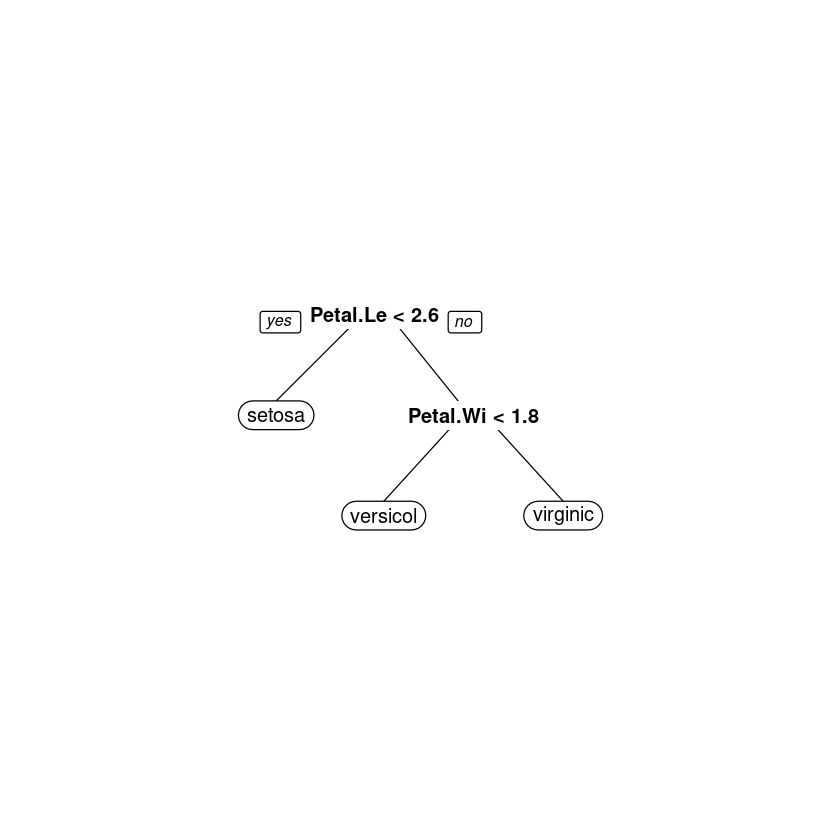

In [36]:
prp(iris_tree)


Classification tree:
rpart(formula = Species ~ ., data = training_set, method = "class", 
    control = tree_control)

Variables actually used in tree construction:
[1] Petal.Length Petal.Width 

Root node error: 66/105 = 0.62857

n= 105 

       CP nsplit rel error   xerror     xstd
1 0.56061      0  1.000000 1.121212 0.070820
2 0.39394      1  0.439394 0.439394 0.069417
3 0.01000      2  0.045455 0.045455 0.025866


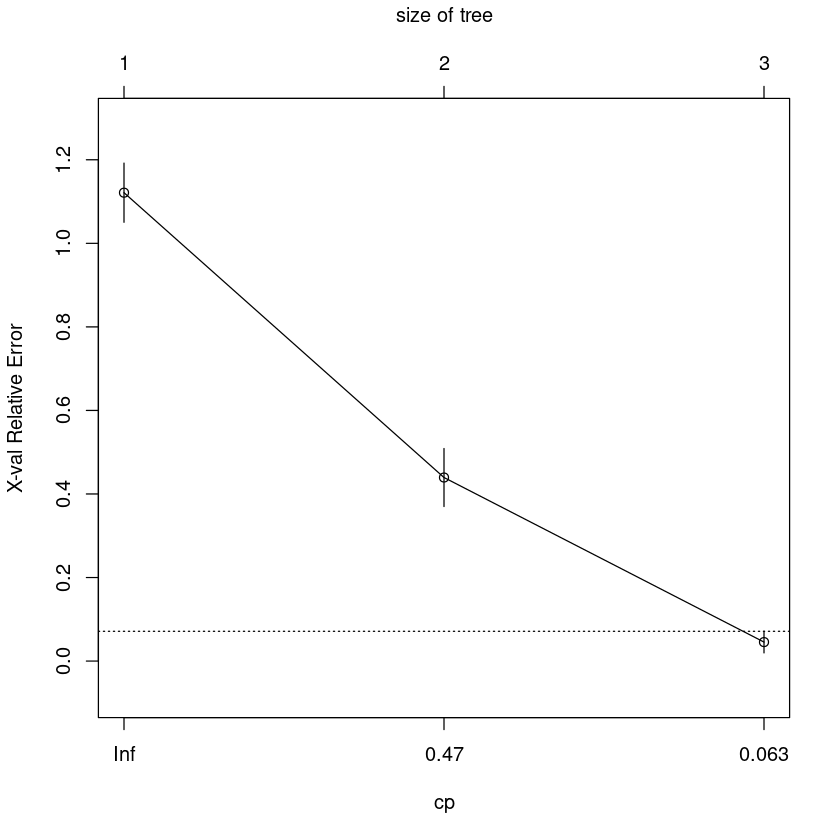

In [30]:
#  complexity parameter table
printcp(iris_tree)
plotcp(iris_tree)

In [37]:
# predictions and evaluation
pred_class = predict(iris_tree, newdata = testing_set, type = "class")
conf_mat = table(Observed = testing_set$Species, Predicted = pred_class)
conf_mat

            Predicted
Observed     setosa versicolor virginica
  setosa         11          0         0
  versicolor      0         13         0
  virginica       0          3        18

In [38]:
accuracy = sum(diag(conf_mat)) / sum(conf_mat)
accuracy

[1] 0.9333333

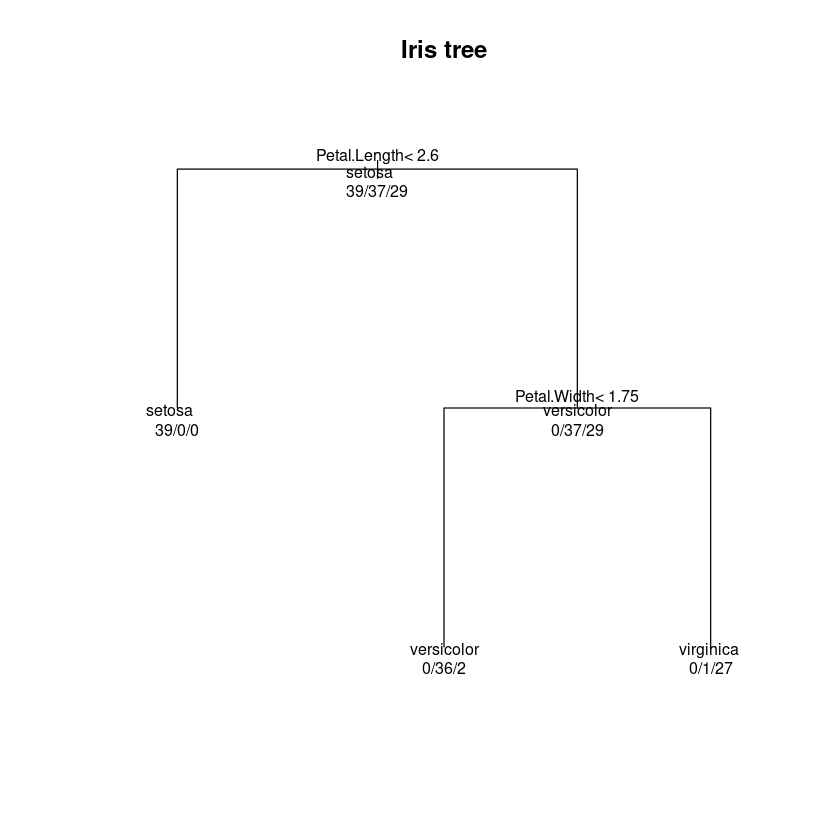

In [39]:
plot(iris_tree, uniform = TRUE, margin = 0.1)
text(iris_tree, use.n = TRUE, all = TRUE, cex = 0.8)
title("Iris tree")


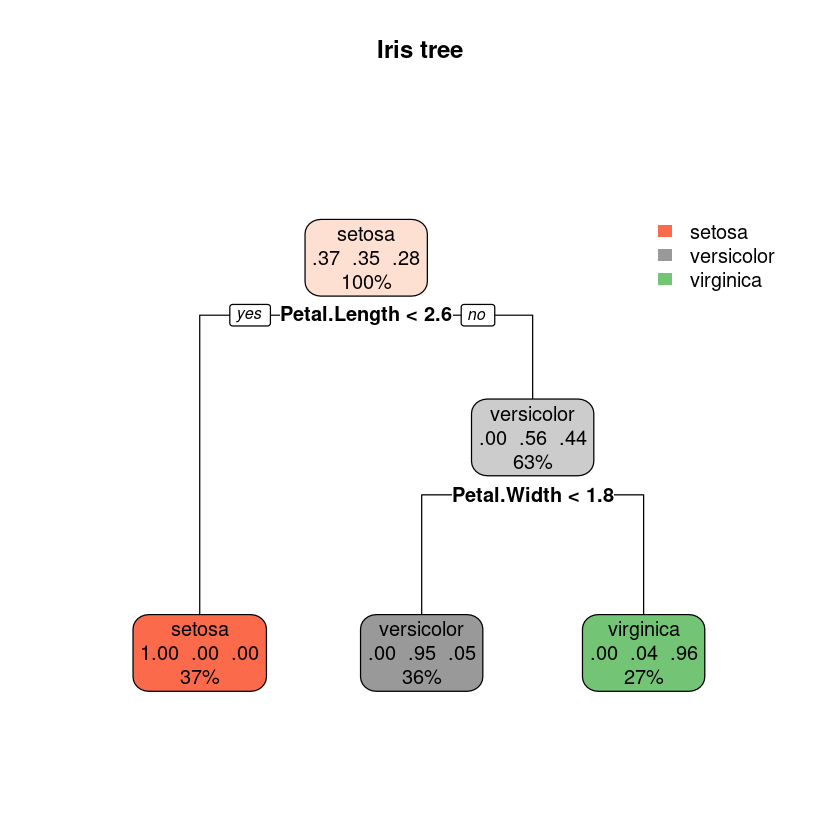

In [40]:
rpart.plot(iris_tree, main = "Iris tree")

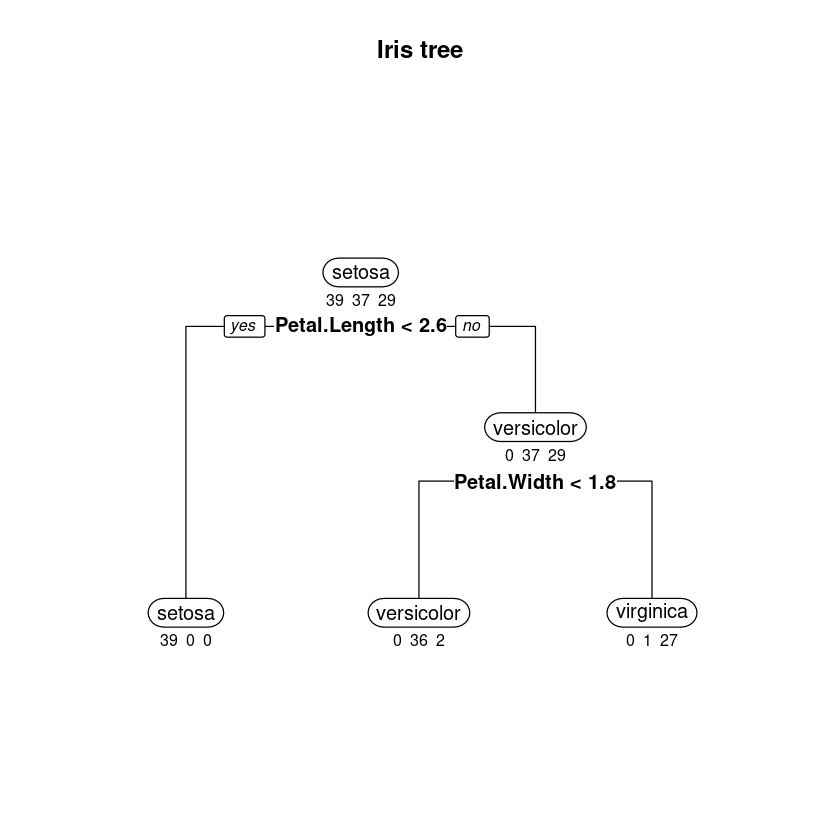

In [41]:
prp(iris_tree,
    type = 2,       
    extra = 1,      
    varlen = 0,      
    faclen = 0,     
    under = TRUE,
    fallen.leaves = TRUE,
    main = "Iris tree")


In [42]:
rpart.rules(iris_tree, cover = TRUE, roundint = FALSE)

,Species,seto vers virg,,,,,,,,,cover
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,setosa,[1.00 .00 .00],when,Petal.Length,<,2.6,,,,,37%
6,versicolor,[ .00 .95 .05],when,Petal.Length,>=,2.6,&,Petal.Width,<,1.8,36%
7,virginica,[ .00 .04 .96],when,Petal.Length,>=,2.6,&,Petal.Width,>=,1.8,27%


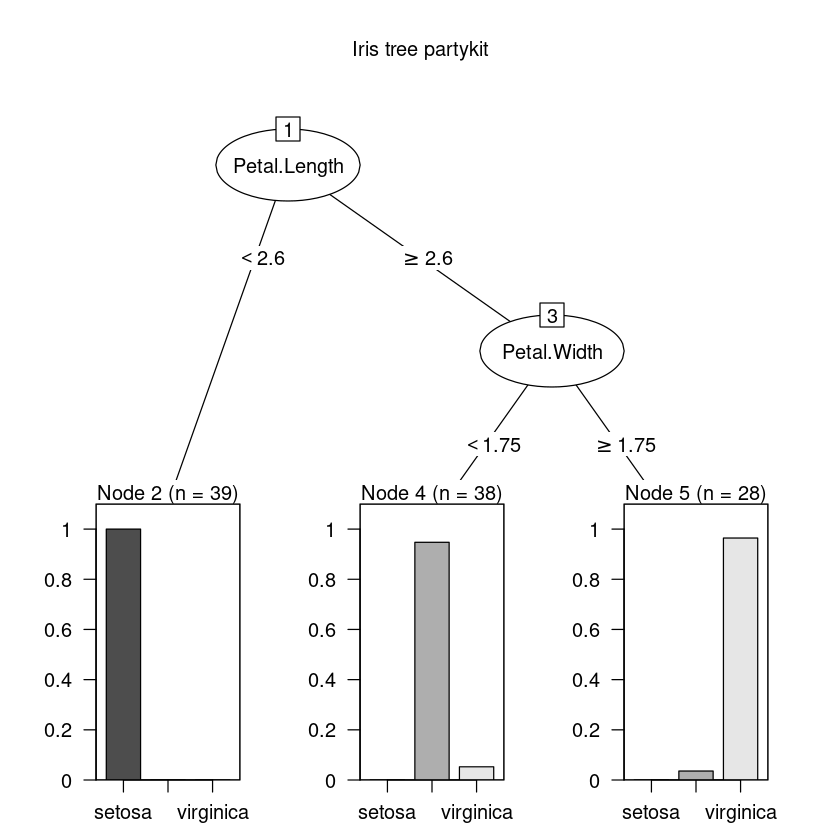

In [43]:
iris_party = as.party(iris_tree)
plot(iris_party, main = "Iris tree partykit")


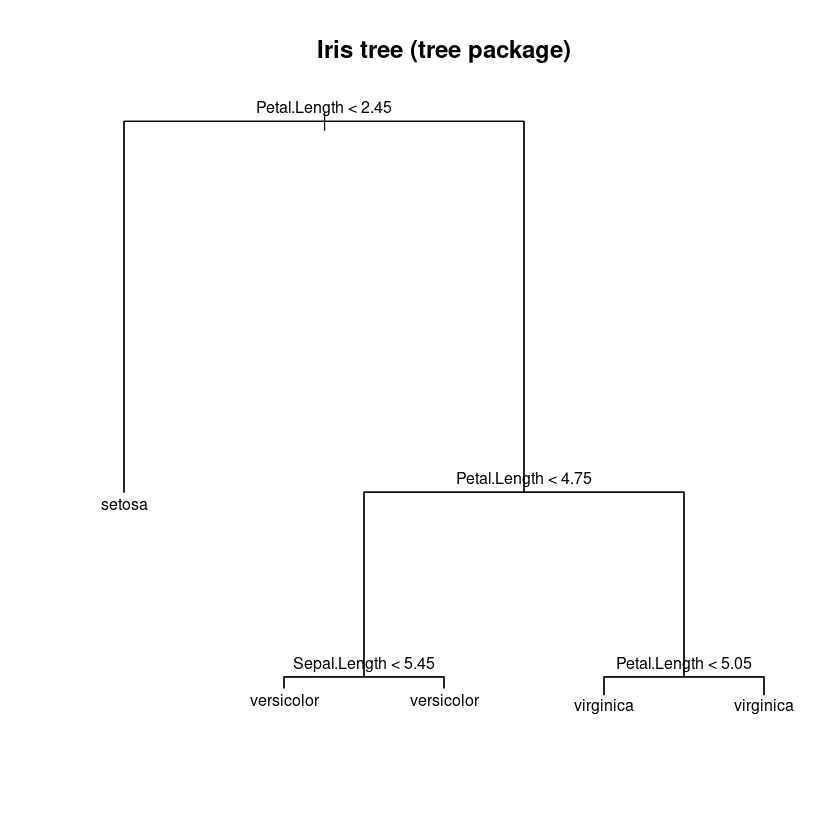

In [20]:
# using the 'tree' package
iris_tree_alt = tree(model_formula, data = training_set)
plot(iris_tree_alt)
text(iris_tree_alt, pretty = 0, cex = 0.8)
title("Iris tree (tree package)")

In [21]:
#rpart fit records a sequence of subtrees with increasing cost complexity parameter $cp$. Cross validation error is reported in the complexity table.
#A common choice is the cp that minimizes cross validation error, or the one standard error rule for a simpler subtree, select the minimizing $cp$, prune, and compare accuracy

In [47]:
cp_table = iris_tree$cptable
print(cp_table)
cp_optimal = cp_table[which.min(cp_table[ , "xerror"]), "CP"]
cp_optimal = 0.39

         CP nsplit  rel error     xerror       xstd
1 0.5606061      0 1.00000000 1.04545455 0.07369486
2 0.3939394      1 0.43939394 0.43939394 0.06941722
3 0.0010000      2 0.04545455 0.09090909 0.03603750


In [48]:
iris_tree_pruned = prune(iris_tree, cp = cp_optimal)

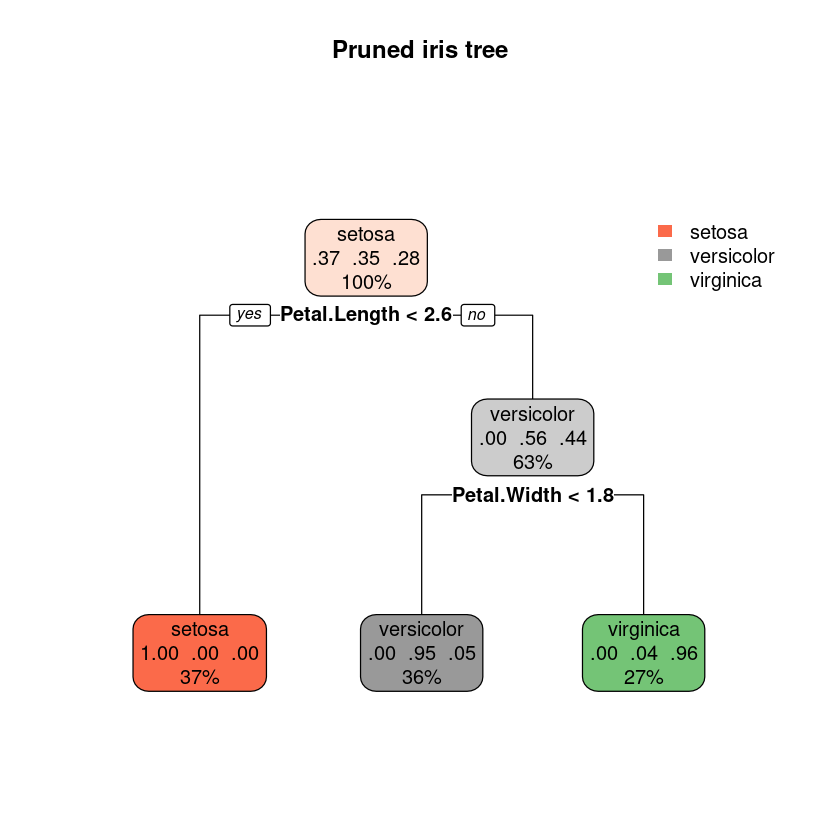

In [49]:
rpart.plot(iris_tree_pruned, main = "Pruned iris tree")

In [50]:
pred_class_pruned = predict(iris_tree_pruned, newdata = testing_set, type = "class")
conf_mat_pruned = table(Observed = testing_set$Species, Predicted = pred_class_pruned)
conf_mat_pruned

            Predicted
Observed     setosa versicolor virginica
  setosa         11          0         0
  versicolor      0         13         0
  virginica       0          3        18

In [51]:

accuracy_pruned = sum(diag(conf_mat_pruned)) / sum(conf_mat_pruned)
c(Accuracy_unpruned = accuracy, Accuracy_pruned = accuracy_pruned)


Accuracy_unpruned   Accuracy_pruned 
        0.9333333         0.9333333

# variable importance

trees can provide a simple measure of feature influence by summing the impurity reduction contributed by each split


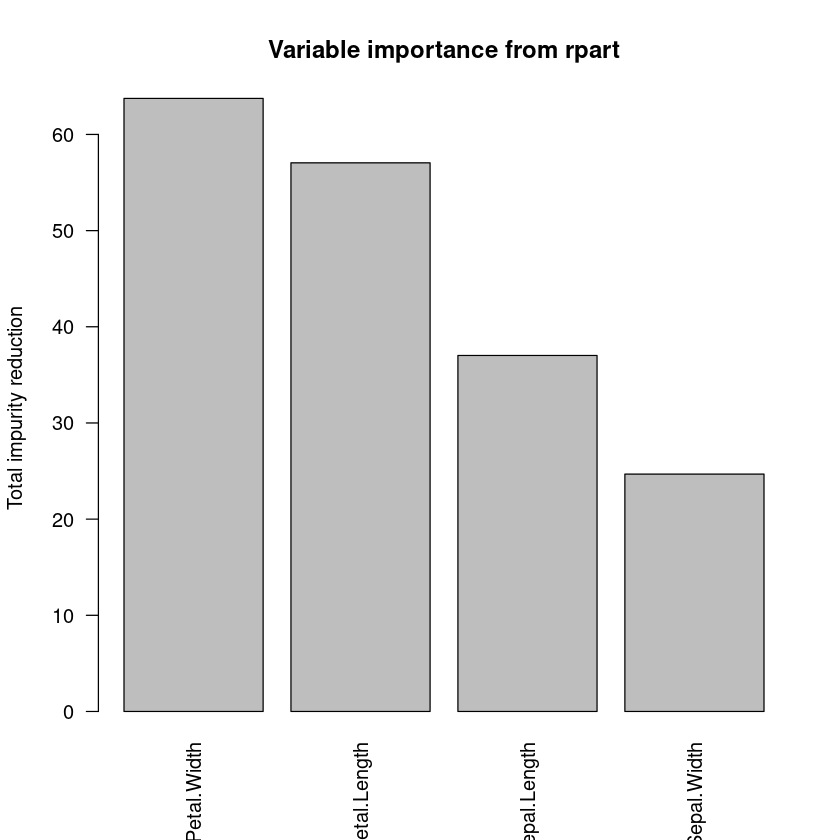

In [52]:
importance_values = iris_tree$variable.importance
importance_values = sort(importance_values, decreasing = TRUE)
barplot(importance_values,
        main = "Variable importance from rpart",
        ylab = "Total impurity reduction",
        las = 2)


In [30]:
# regression 

In [53]:
dataset_reg = mtcars

In [54]:
n_reg = nrow(dataset_reg)
test_fraction_reg = 0.30
test_index_reg = sample(seq_len(n_reg), size = floor(test_fraction_reg * n_reg))
training_set_reg = dataset_reg[-test_index_reg, ]
testing_set_reg  = dataset_reg[test_index_reg, ]

In [55]:
response_reg = "mpg"
predictors_reg = setdiff(names(dataset_reg), response_reg)
formula_str_reg = paste(response_reg, "~", paste(predictors_reg, collapse = " + "))
model_formula_reg = as.formula(formula_str_reg)


In [57]:
tree_control_reg = rpart.control(minsplit = 6, minbucket = 3, maxdepth = 6, cp = 0.001, xval = 10)
mtcars_tree = rpart(mpg ~ .,
                    data = training_set_reg,
                    method = "anova",
                    control = tree_control_reg)



Regression tree:
rpart(formula = mpg ~ ., data = training_set_reg, method = "anova", 
    control = tree_control_reg)

Variables actually used in tree construction:
[1] cyl  disp hp   qsec

Root node error: 651.42/23 = 28.322

n= 23 

         CP nsplit rel error  xerror     xstd
1 0.6827935      0  1.000000 1.07673 0.316240
2 0.1096342      1  0.317206 0.51280 0.130223
3 0.0875655      2  0.207572 0.41083 0.097503
4 0.0327188      3  0.120007 0.39330 0.111192
5 0.0053226      4  0.087288 0.31728 0.093980
6 0.0051810      5  0.081965 0.34447 0.103415
7 0.0010000      6  0.076784 0.34447 0.103415


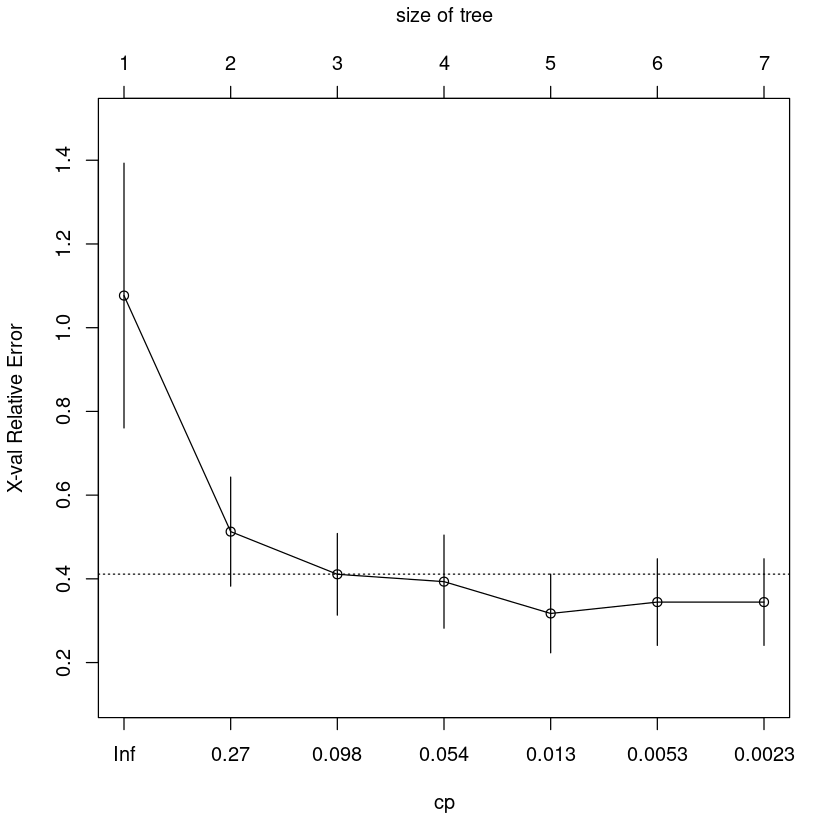

In [58]:
printcp(mtcars_tree)
plotcp(mtcars_tree)

In [59]:
pred_reg = predict(mtcars_tree, newdata = testing_set_reg)
residuals_reg = testing_set_reg$mpg - pred_reg
mae = mean(abs(residuals_reg))
rmse = sqrt(mean(residuals_reg^2))
c(MAE = mae, RMSE = rmse)

MAE     RMSE 
2.233333 2.548587

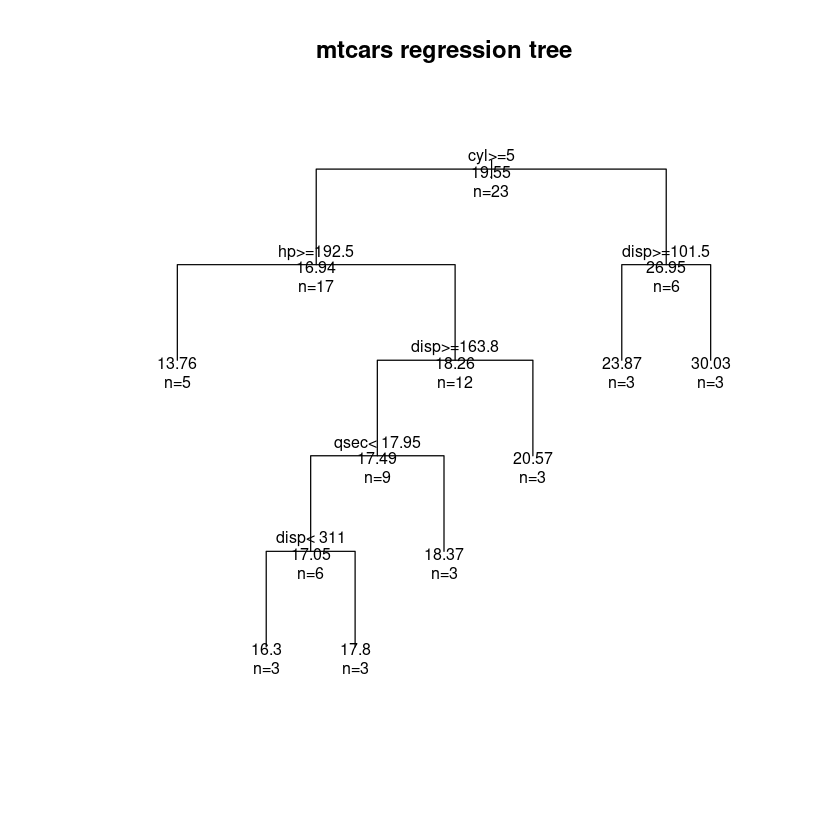

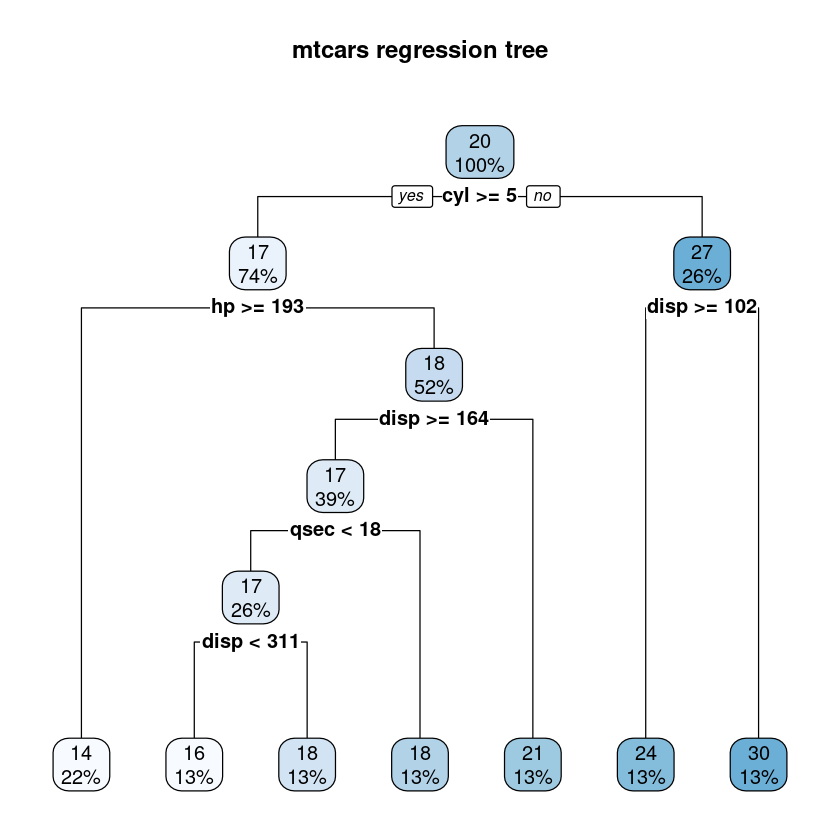

In [60]:
par(xpd = NA)
plot(mtcars_tree, uniform = TRUE, margin = 0.1)
text(mtcars_tree, use.n = TRUE, all = TRUE, cex = 0.8)
title("mtcars regression tree")

rpart.plot(mtcars_tree, main = "mtcars regression tree")


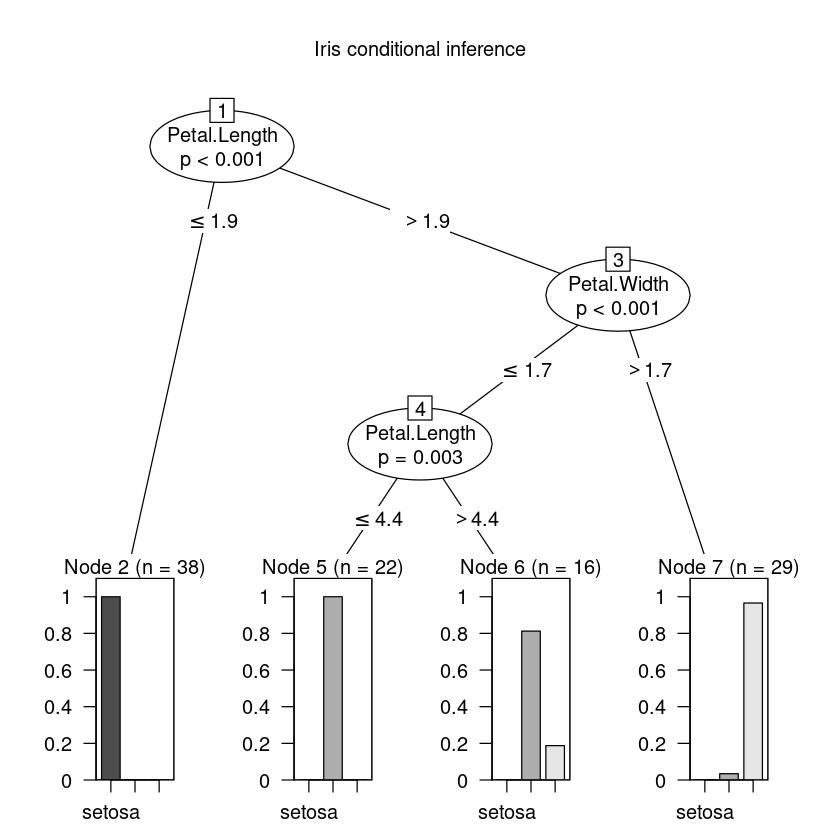

In [38]:
# conditional inference tree with iris
iris_ctree = ctree(model_formula, data = training_set)  
plot(iris_ctree, main = "Iris conditional inference")


In [39]:
pred_ctree = predict(iris_ctree, newdata = testing_set, type = "response")
conf_mat_ctree = table(Observed = testing_set$Species, Predicted = pred_ctree)
conf_mat_ctree
accuracy_ctree = sum(diag(conf_mat_ctree)) / sum(conf_mat_ctree)
c(Accuracy_ctree = accuracy_ctree)

            Predicted
Observed     setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         14         0
  virginica       0          2        17

Accuracy_ctree 
     0.9555556

In [65]:
dataset = kyphosis  
head(dataset)

,Kyphosis,Age,Number,Start
,<fct>,<int>,<int>,<int>
1,absent,71,3,5
2,absent,158,3,14
3,present,128,4,5
4,absent,2,5,1
5,absent,1,4,15
6,absent,1,2,16


In [66]:
dataset$Kyphosis = factor(dataset$Kyphosis)


In [67]:

n = nrow(dataset)
test_fraction = 0.30
test_index = sample(seq_len(n), size = floor(test_fraction * n))
training_set = dataset[-test_index, ]
testing_set  = dataset[test_index, ]


In [68]:
tree_control = rpart.control(cp = 0.001, minsplit = 5, minbucket = 2, maxdepth = 10, xval = 10)

In [69]:
ky_tree = rpart(Kyphosis ~ . , data = training_set, method = "class", control = tree_control)

In [70]:
printcp(ky_tree)


Classification tree:
rpart(formula = Kyphosis ~ ., data = training_set, method = "class", 
    control = tree_control)

Variables actually used in tree construction:
[1] Start

Root node error: 16/57 = 0.2807

n= 57 

       CP nsplit rel error xerror    xstd
1 0.50000      0    1.0000  1.000 0.21203
2 0.09375      1    0.5000  0.625 0.17947
3 0.00100      3    0.3125  0.750 0.19237


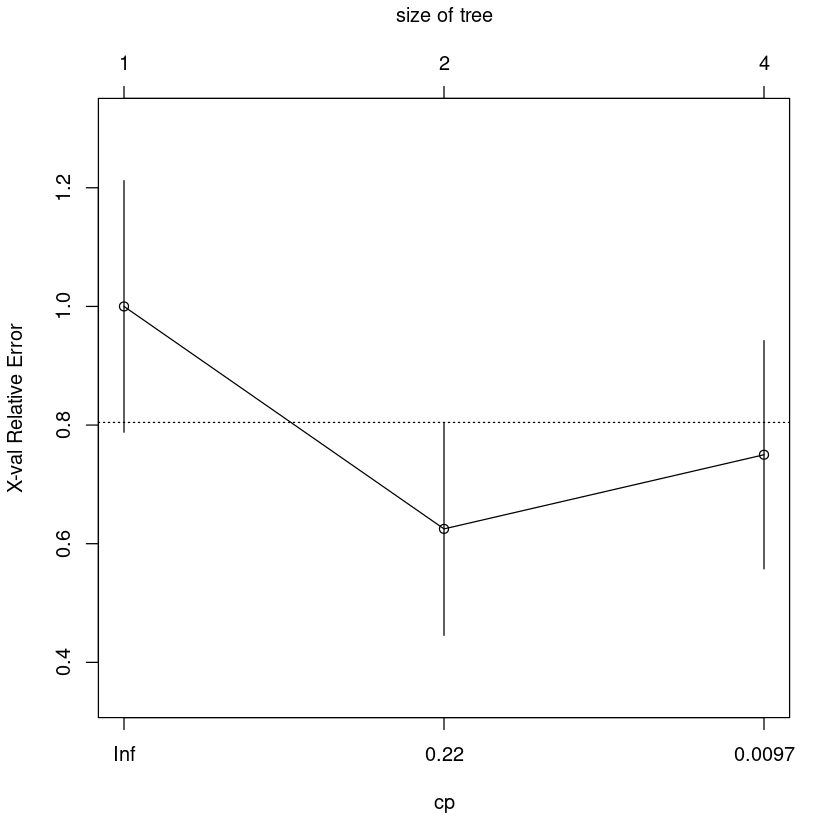

In [71]:
plotcp(ky_tree)

In [73]:
pred_train = predict(ky_tree, newdata = training_set, type = "class")
pred_test  = predict(ky_tree, newdata = testing_set,  type = "class")

head(pred_train)

2       3       4       7       9      10 
 absent present present  absent  absent present 
Levels: absent present

In [74]:
train_error_baseline = mean(pred_train != training_set$Kyphosis)
test_error_baseline  = mean(pred_test  != testing_set$Kyphosis)

In [75]:
c(Train_error_baseline = train_error_baseline, Test_error_baseline = test_error_baseline)

Train_error_baseline  Test_error_baseline 
           0.0877193            0.3333333

In [76]:
depth_values = 1:10
train_error = numeric(length(depth_values))
test_error  = numeric(length(depth_values))
leaf_count  = integer(length(depth_values))

In [77]:

response = "Kyphosis"
predictors = setdiff(names(dataset), response)
model_formula = as.formula(paste(response, "~", paste(predictors, collapse = " + ")))

for (i in seq_along(depth_values)) {
  mdl = rpart(model_formula,
              data = training_set,
              method = "class",
              control = rpart.control(cp = 0.0, minsplit = 5, minbucket = 2,
                                      maxdepth = depth_values[i], xval = 0))
  pred_tr = predict(mdl, newdata = training_set, type = "class")
  pred_te = predict(mdl, newdata = testing_set,  type = "class")
  train_error[i] = mean(pred_tr != training_set$Kyphosis)
  test_error[i]  = mean(pred_te != testing_set$Kyphosis)
  leaf_count[i]  = sum(mdl$frame$var == "<leaf>")
}

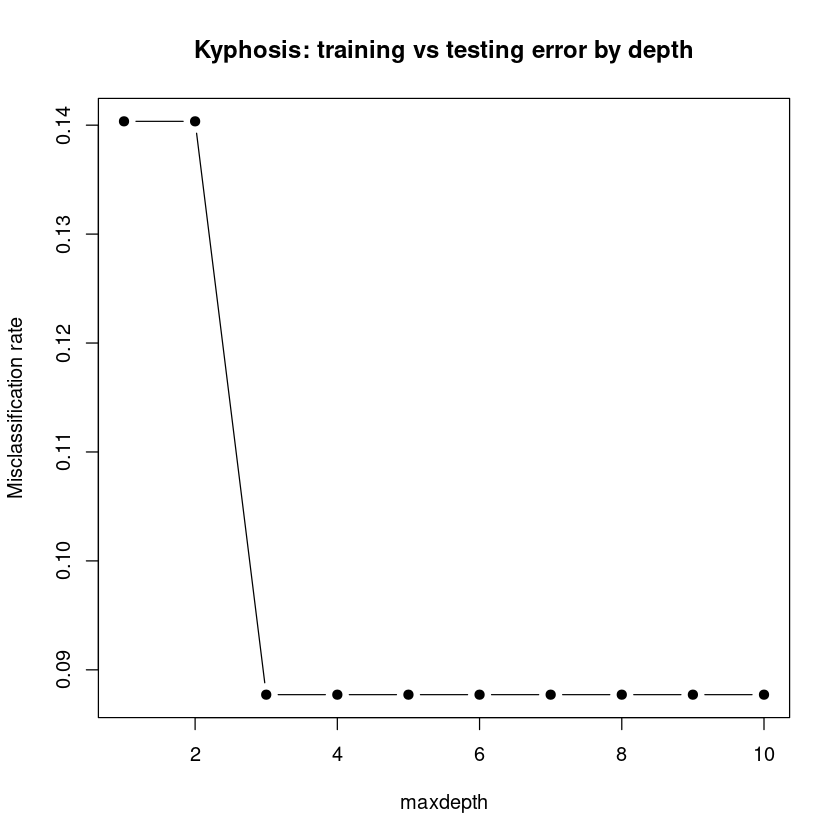

In [78]:
plot(depth_values, train_error, type = "b", pch = 19,
     xlab = "maxdepth", ylab = "Misclassification rate",
     main = "Kyphosis: training vs testing error by depth")
lines(depth_values, test_error, type = "b", pch = 1)


In [79]:
best_depth = depth_values[which.min(test_error)]
best_depth

[1] 1

In [98]:
best_depth = 30

In [99]:
ky_tree_bestdepth = rpart(model_formula,
                          data = training_set,
                          method = "class",
                          control = rpart.control(cp = 0.0, minsplit = 5, minbucket = 2,
                                                  maxdepth = best_depth, xval = 0))


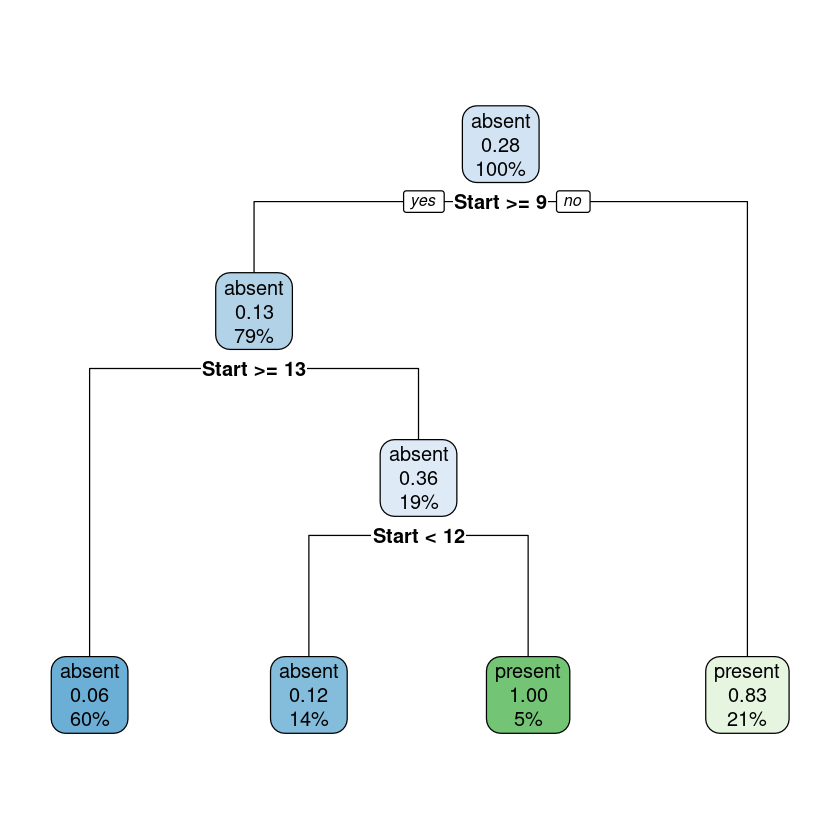

In [100]:
rpart.plot(ky_tree_bestdepth)

In [101]:

pred_train_best = predict(ky_tree_bestdepth, newdata = training_set, type = "class")
pred_test_best  = predict(ky_tree_bestdepth,  newdata = testing_set,  type = "class")
train_error_best = mean(pred_train_best != training_set$Kyphosis)
test_error_best  = mean(pred_test_best  != testing_set$Kyphosis)


In [102]:
cp_table = ky_tree$cptable
cp_optimal = cp_table[which.min(cp_table[ , "xerror"]), "CP"]
ky_tree_pruned = prune(ky_tree, cp = cp_optimal)

pred_train_pruned = predict(ky_tree_pruned, newdata = training_set, type = "class")
pred_test_pruned  = predict(ky_tree_pruned,  newdata = testing_set,  type = "class")

train_error_pruned = mean(pred_train_pruned != training_set$Kyphosis)
test_error_pruned  = mean(pred_test_pruned  != testing_set$Kyphosis)


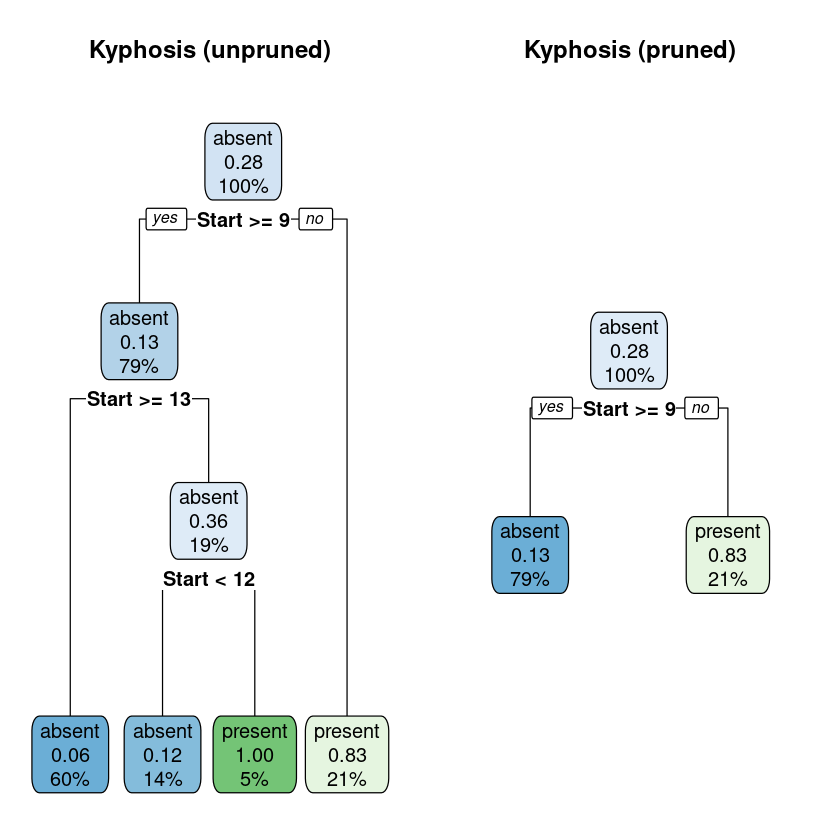

In [103]:
par(mfrow = c(1, 2))
rpart.plot(ky_tree, main = "Kyphosis (unpruned)")
rpart.plot(ky_tree_pruned, main = "Kyphosis (pruned)")
par(mfrow = c(1, 1))

In [74]:
# air quality

In [105]:
dataset_reg = na.omit(airquality)
response_reg = "Ozone"
predictors_reg = setdiff(names(dataset_reg), response_reg)
model_formula_reg = as.formula(paste(response_reg, "~", paste(predictors_reg, collapse = " + ")))


In [106]:

n_reg = nrow(dataset_reg)
test_fraction_reg = 0.30
test_index_reg = sample(seq_len(n_reg), size = floor(test_fraction_reg * n_reg))
training_set_reg = dataset_reg[-test_index_reg, ]
testing_set_reg  = dataset_reg[test_index_reg, ]


In [107]:

tree_control_reg = rpart.control(cp = 0.001, minsplit = 10, minbucket = 5, maxdepth = 10, xval = 10)
aq_tree = rpart(model_formula_reg, data = training_set_reg, method = "anova", control = tree_control_reg)



Regression tree:
rpart(formula = model_formula_reg, data = training_set_reg, method = "anova", 
    control = tree_control_reg)

Variables actually used in tree construction:
[1] Day     Solar.R Temp    Wind   

Root node error: 94153/78 = 1207.1

n= 78 

          CP nsplit rel error  xerror    xstd
1  0.5395746      0   1.00000 1.04017 0.21527
2  0.1595771      1   0.46043 0.75596 0.22404
3  0.0427279      2   0.30085 0.44947 0.12786
4  0.0326106      3   0.25812 0.46106 0.13001
5  0.0129632      4   0.22551 0.43662 0.13026
6  0.0124175      5   0.21255 0.45191 0.13095
7  0.0110899      6   0.20013 0.45078 0.13099
8  0.0055009      7   0.18904 0.44775 0.13111
9  0.0035510      8   0.18354 0.45932 0.13268
10 0.0026220      9   0.17999 0.45724 0.13273
11 0.0010000     10   0.17737 0.45656 0.13282


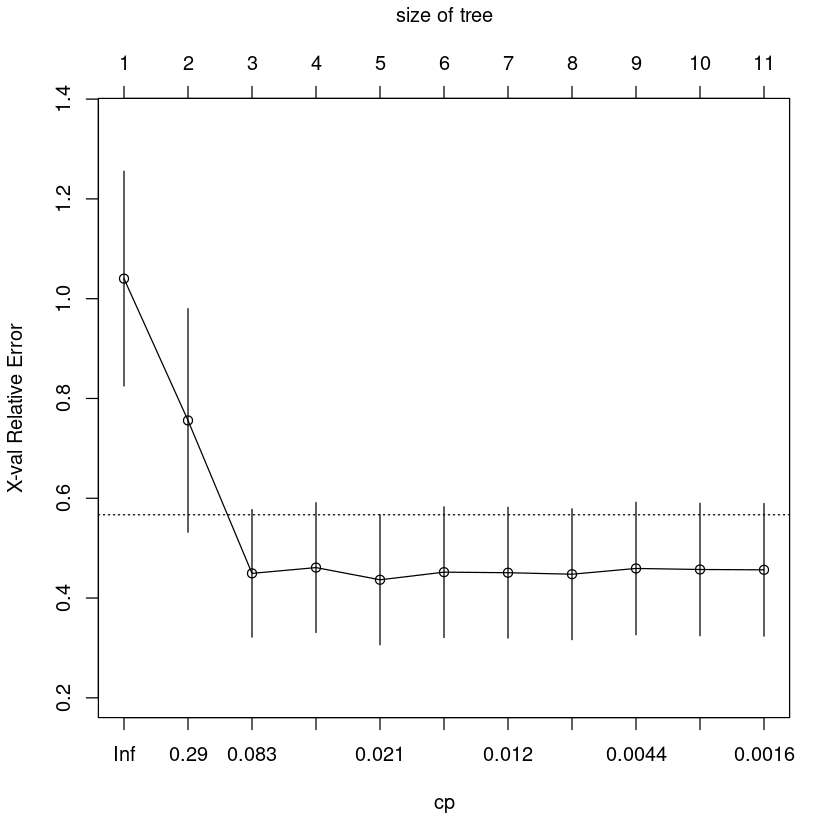

In [108]:

printcp(aq_tree)
plotcp(aq_tree)


In [109]:

pred_train_reg = predict(aq_tree, newdata = training_set_reg)
pred_test_reg  = predict(aq_tree, newdata = testing_set_reg)
res_tr = training_set_reg$Ozone - pred_train_reg
res_te = testing_set_reg$Ozone  - pred_test_reg
rmse_tr_baseline = sqrt(mean(res_tr^2))
rmse_te_baseline = sqrt(mean(res_te^2))


In [110]:
depth_values_reg = 1:12
rmse_train = numeric(length(depth_values_reg))
rmse_test  = numeric(length(depth_values_reg))
leaves_reg = integer(length(depth_values_reg))

for (i in seq_along(depth_values_reg)) {
  mdl = rpart(model_formula_reg,
              data = training_set_reg,
              method = "anova",
              control = rpart.control(cp = 0.0, minsplit = 5, minbucket = 3,
                                      maxdepth = depth_values_reg[i], xval = 0))
  pred_tr = predict(mdl, newdata = training_set_reg)
  pred_te = predict(mdl, newdata = testing_set_reg)
  rmse_train[i] = sqrt(mean((training_set_reg$Ozone - pred_tr)^2))
  rmse_test[i]  = sqrt(mean((testing_set_reg$Ozone  - pred_te)^2))
  leaves_reg[i] = sum(mdl$frame$var == "<leaf>")
}


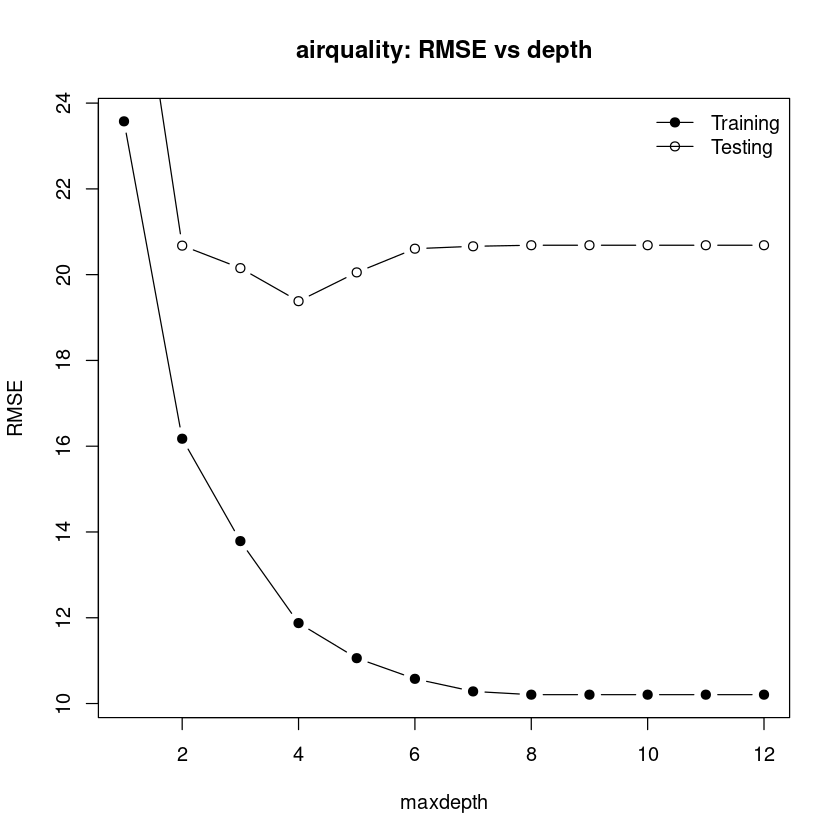

In [111]:

plot(depth_values_reg, rmse_train, type = "b", pch = 19,
     xlab = "maxdepth", ylab = "RMSE",
     main = "airquality: RMSE vs depth")
lines(depth_values_reg, rmse_test, type = "b", pch = 1)
legend("topright", legend = c("Training", "Testing"), lty = 1, pch = c(19, 1), bty = "n")


In [112]:

best_depth_reg = depth_values_reg[which.min(rmse_test)]
best_depth_reg

[1] 4

In [113]:
aq_tree_bestdepth = rpart(model_formula_reg, data = training_set_reg,
                          method = "anova",
                          control = rpart.control(cp = 0.0, minsplit = 5, minbucket = 3,
                                                  maxdepth = best_depth_reg, xval = 0))


In [114]:

pred_tr_best = predict(aq_tree_bestdepth, newdata = training_set_reg)
pred_te_best = predict(aq_tree_bestdepth, newdata = testing_set_reg)


In [125]:

rmse_tr_best = sqrt(mean((training_set_reg$Ozone - pred_tr_best)^2))
rmse_te_best = sqrt(mean((testing_set_reg$Ozone  - pred_te_best)^2))
print(rmse_tr_best)
print(rmse_te_best)

[1] 11.87593
[1] 19.38161


In [124]:
cp_table_reg = aq_tree$cptable
cp_optimal_reg = cp_table_reg[which.min(cp_table_reg[ , "xerror"]), "CP"]
aq_tree_pruned = prune(aq_tree, cp = cp_optimal_reg)
print(cp_table_reg)


            CP nsplit rel error    xerror      xstd
1  0.539574618      0 1.0000000 1.0401674 0.2152698
2  0.159577067      1 0.4604254 0.7559623 0.2240367
3  0.042727869      2 0.3008483 0.4494702 0.1278614
4  0.032610630      3 0.2581204 0.4610607 0.1300053
5  0.012963248      4 0.2255098 0.4366242 0.1302616
6  0.012417500      5 0.2125466 0.4519124 0.1309514
7  0.011089907      6 0.2001291 0.4507765 0.1309937
8  0.005500907      7 0.1890392 0.4477550 0.1311081
9  0.003551020      8 0.1835383 0.4593240 0.1326761
10 0.002621972      9 0.1799872 0.4572397 0.1327344
11 0.001000000     10 0.1773653 0.4565599 0.1328166


In [123]:

pred_tr_pruned = predict(aq_tree_pruned, newdata = training_set_reg)
pred_te_pruned = predict(aq_tree_pruned, newdata = testing_set_reg)
#print(pred_tr_pruned)
#print(pred_te_pruned)

In [126]:
print(rmse_tr_best)
print(rmse_te_best)
print("-----------")
rmse_tr_pruned = sqrt(mean((training_set_reg$Ozone - pred_tr_pruned)^2))
rmse_te_pruned = sqrt(mean((testing_set_reg$Ozone  - pred_te_pruned)^2))
print(rmse_tr_pruned)
print(rmse_te_pruned)

[1] 11.87593
[1] 19.38161


[1] "-----------"
[1] 16.49881
[1] 20.4933


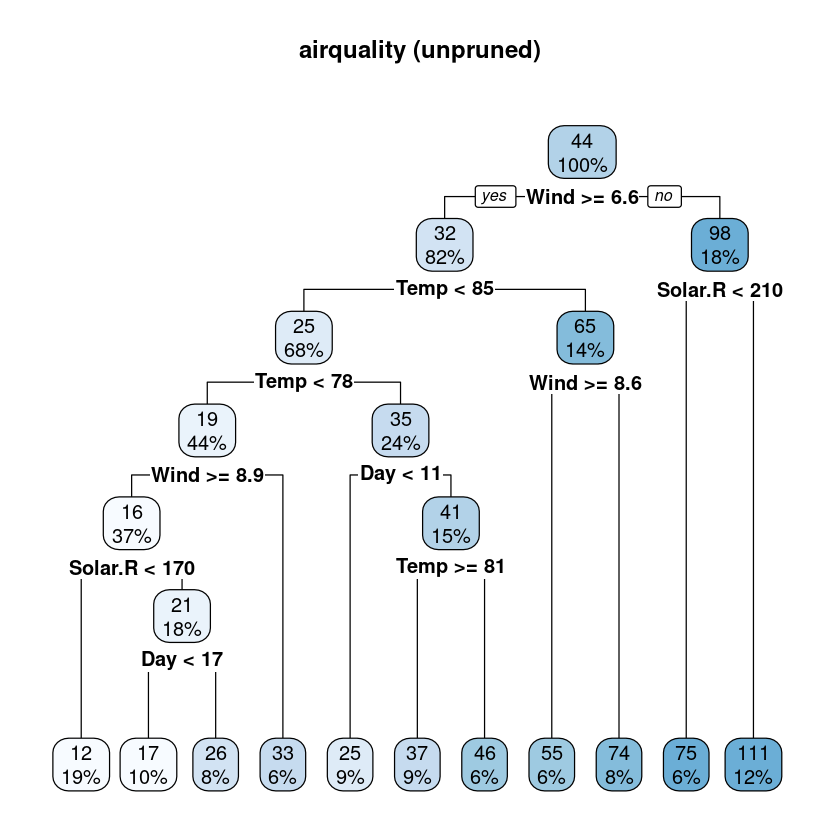

In [120]:
rpart.plot(aq_tree, main = "airquality (unpruned)")


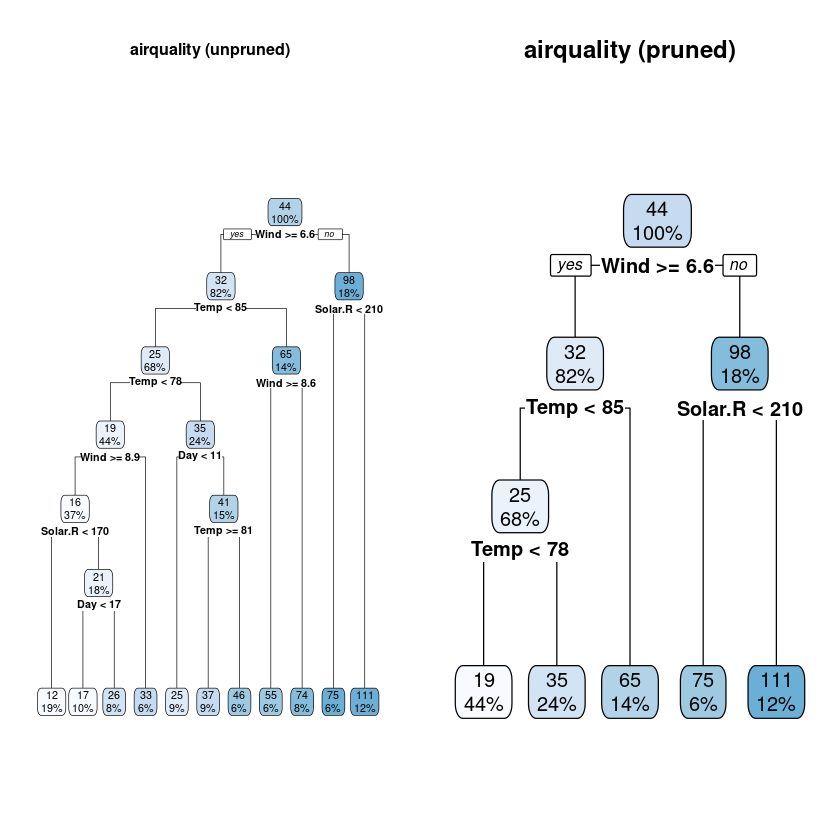

In [119]:
par(mfrow = c(1, 2))
rpart.plot(aq_tree, main = "airquality (unpruned)")
rpart.plot(aq_tree_pruned, main = "airquality (pruned)")
par(mfrow = c(1, 1))

In [127]:
dataset_iris = iris

In [128]:
n_i = nrow(dataset_iris)
test_fraction_i = 0.30
test_index_i = sample(seq_len(n_i), size = floor(test_fraction_i * n_i))
training_set_i = dataset_iris[-test_index_i, ]
testing_set_i  = dataset_iris[test_index_i, ]


In [129]:
iris_tree_unpruned = tree(Species ~ ., data = training_set_i)

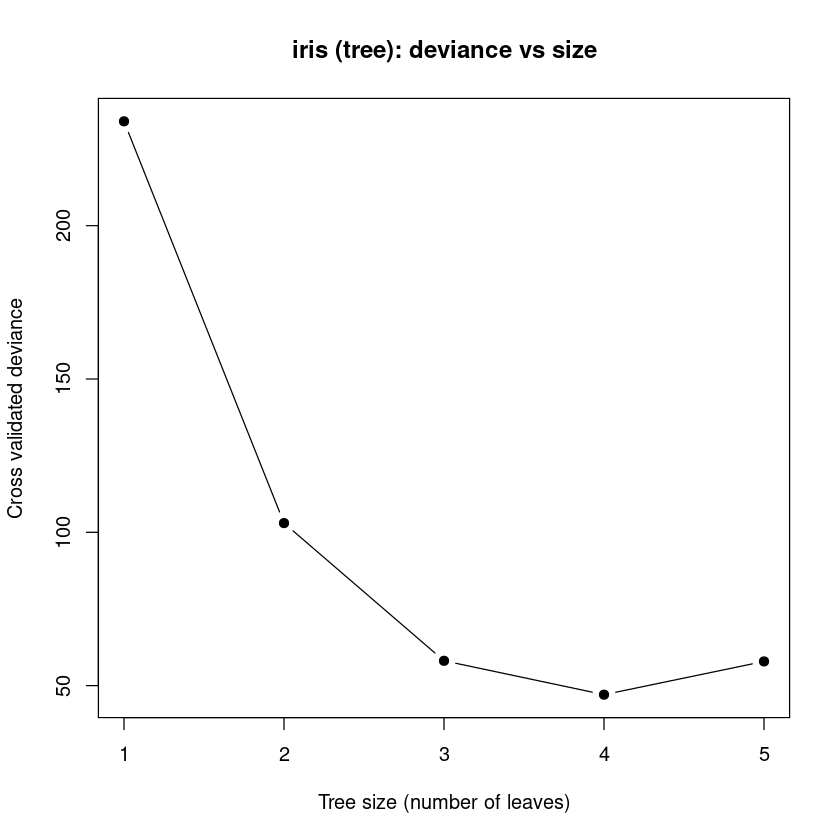

In [131]:
cv_res = cv.tree(iris_tree_unpruned)
plot(cv_res$size, cv_res$dev, type = "b", pch = 19,
     xlab = "Tree size (number of leaves)",
     ylab = "Cross validated deviance",
     main = "iris (tree): deviance vs size")

In [132]:
best_size = cv_res$size[which.min(cv_res$dev)]
best_size

[1] 4

In [133]:
best_size = 2

In [134]:
iris_tree_pruned = prune.tree(iris_tree_unpruned, best = best_size)

In [135]:
pred_tr_un = predict(iris_tree_unpruned, newdata = training_set_i, type = "class")
pred_te_un = predict(iris_tree_unpruned, newdata = testing_set_i,  type = "class")
train_err_un = mean(pred_tr_un != training_set_i$Species)
test_err_un  = mean(pred_te_un != testing_set_i$Species)


In [136]:

pred_tr_pr = predict(iris_tree_pruned, newdata = training_set_i, type = "class")
pred_te_pr = predict(iris_tree_pruned, newdata = testing_set_i,  type = "class")
train_err_pr = mean(pred_tr_pr != training_set_i$Species)
test_err_pr  = mean(pred_te_pr != testing_set_i$Species)


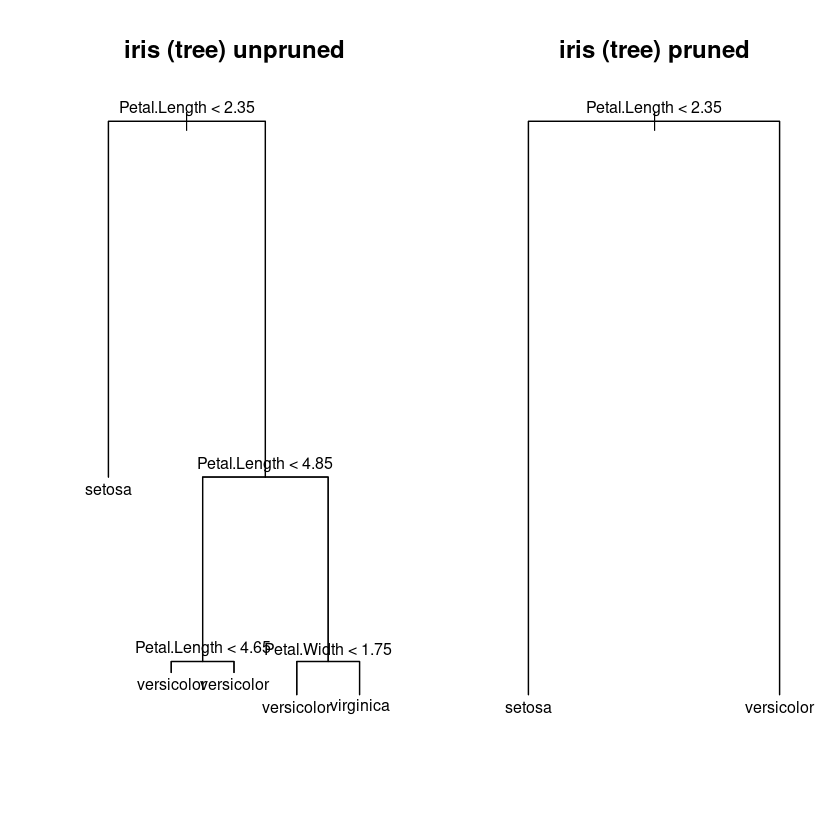

In [137]:
par(mfrow = c(1, 2))
plot(iris_tree_unpruned); 
text(iris_tree_unpruned, pretty = 0, cex = 0.8); 
title("iris (tree) unpruned")
plot(iris_tree_pruned);   
text(iris_tree_pruned, pretty = 0, cex = 0.8); 
title("iris (tree) pruned")
par(mfrow = c(1, 1))

         CP nsplit  rel error    xerror       xstd
1 0.5000000      0 1.00000000 1.1029412 0.06807501
2 0.4411765      1 0.50000000 0.5441176 0.07198662
3 0.0010000      2 0.05882353 0.1029412 0.03758880


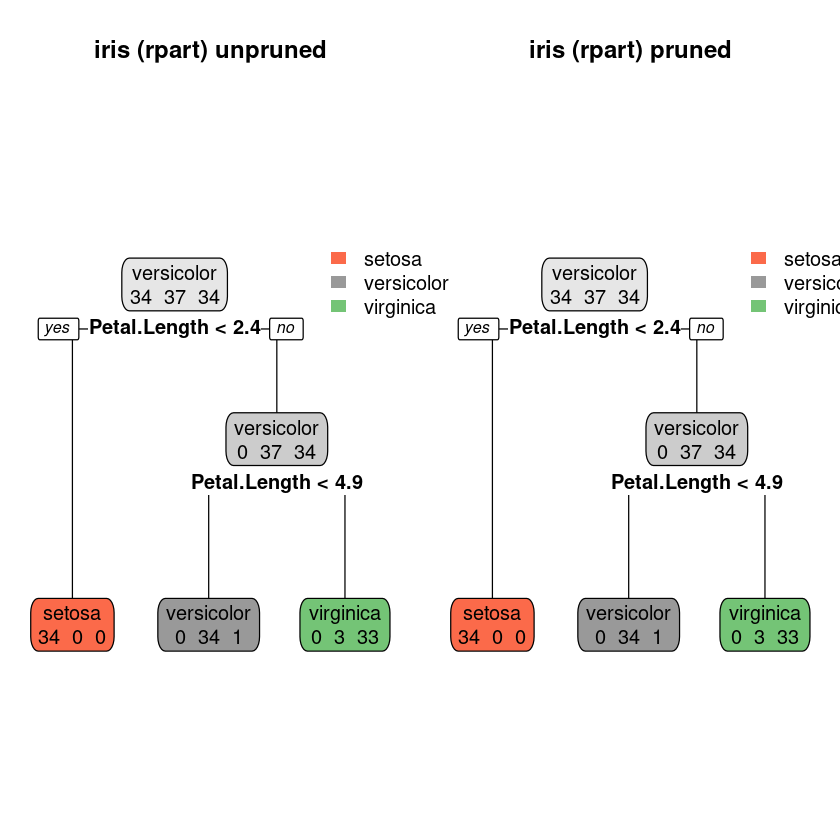

In [138]:
iris_tree_rpart = rpart(Species ~ .,
                        data = training_set_i,
                        method = "class",
                        control = rpart.control(cp = 0.001, minsplit = 10, minbucket = 4, maxdepth = 10, xval = 10))

# find cp that minimizes cross-validated error and prune
cp_table = iris_tree_rpart$cptable
print(cp_table)
cp_optimal = cp_table[which.min(cp_table[ , "xerror"]), "CP"]
iris_tree_rpart_pruned = prune(iris_tree_rpart, cp = cp_optimal)

par(mfrow = c(1, 2))
rpart.plot(iris_tree_rpart, main = "iris (rpart) unpruned", type = 2, extra = 1, varlen = 0, faclen = 0)
rpart.plot(iris_tree_rpart_pruned, main = "iris (rpart) pruned", type = 2, extra = 1, varlen = 0, faclen = 0)
par(mfrow = c(1, 1))

In [139]:
library(mlbench)

In [140]:
data(Sonar)     # 60 predictors  Class in {M, R}
dataset = Sonar
str(dataset)

'data.frame':	208 obs. of  61 variables:
 $ V1   : num  0.02 0.0453 0.0262 0.01 0.0762 0.0286 0.0317 0.0519 0.0223 0.0164 ...
 $ V2   : num  0.0371 0.0523 0.0582 0.0171 0.0666 0.0453 0.0956 0.0548 0.0375 0.0173 ...
 $ V3   : num  0.0428 0.0843 0.1099 0.0623 0.0481 ...
 $ V4   : num  0.0207 0.0689 0.1083 0.0205 0.0394 ...
 $ V5   : num  0.0954 0.1183 0.0974 0.0205 0.059 ...
 $ V6   : num  0.0986 0.2583 0.228 0.0368 0.0649 ...
 $ V7   : num  0.154 0.216 0.243 0.11 0.121 ...
 $ V8   : num  0.16 0.348 0.377 0.128 0.247 ...
 $ V9   : num  0.3109 0.3337 0.5598 0.0598 0.3564 ...
 $ V10  : num  0.211 0.287 0.619 0.126 0.446 ...
 $ V11  : num  0.1609 0.4918 0.6333 0.0881 0.4152 ...
 $ V12  : num  0.158 0.655 0.706 0.199 0.395 ...
 $ V13  : num  0.2238 0.6919 0.5544 0.0184 0.4256 ...
 $ V14  : num  0.0645 0.7797 0.532 0.2261 0.4135 ...
 $ V15  : num  0.066 0.746 0.648 0.173 0.453 ...
 $ V16  : num  0.227 0.944 0.693 0.213 0.533 ...
 $ V17  : num  0.31 1 0.6759 0.0693 0.7306 ...
 $ V18  : num  0.

In [141]:
n = nrow(dataset)
test_fraction = 0.30
test_index = sample(seq_len(n), size = floor(test_fraction * n))
training_set = dataset[-test_index, ]
testing_set  = dataset[test_index, ]


In [142]:
tree_control = rpart.control(cp = 0.001, minsplit = 10, minbucket = 5, maxdepth = 20, xval = 10)
sonar_tree = rpart(Class ~ ., data = training_set, method = "class", control = tree_control)



Classification tree:
rpart(formula = Class ~ ., data = training_set, method = "class", 
    control = tree_control)

Variables actually used in tree construction:
[1] V11 V15 V17 V20 V36 V4  V41 V44 V51

Root node error: 67/146 = 0.4589

n= 146 

         CP nsplit rel error  xerror     xstd
1 0.4925373      0   1.00000 1.00000 0.089867
2 0.0746269      1   0.50746 0.59701 0.080433
3 0.0597015      3   0.35821 0.64179 0.082206
4 0.0447761      4   0.29851 0.65672 0.082751
5 0.0373134      5   0.25373 0.55224 0.078445
6 0.0149254      7   0.17910 0.56716 0.079132
7 0.0074627      8   0.16418 0.59701 0.080433
8 0.0010000     10   0.14925 0.59701 0.080433


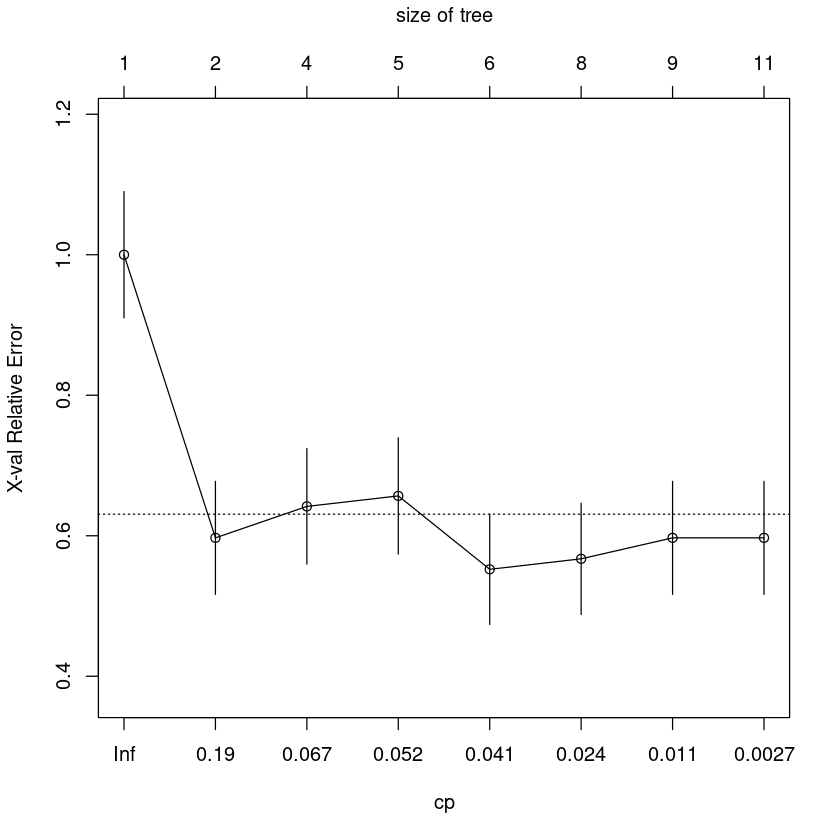

In [143]:

printcp(sonar_tree)
plotcp(sonar_tree)


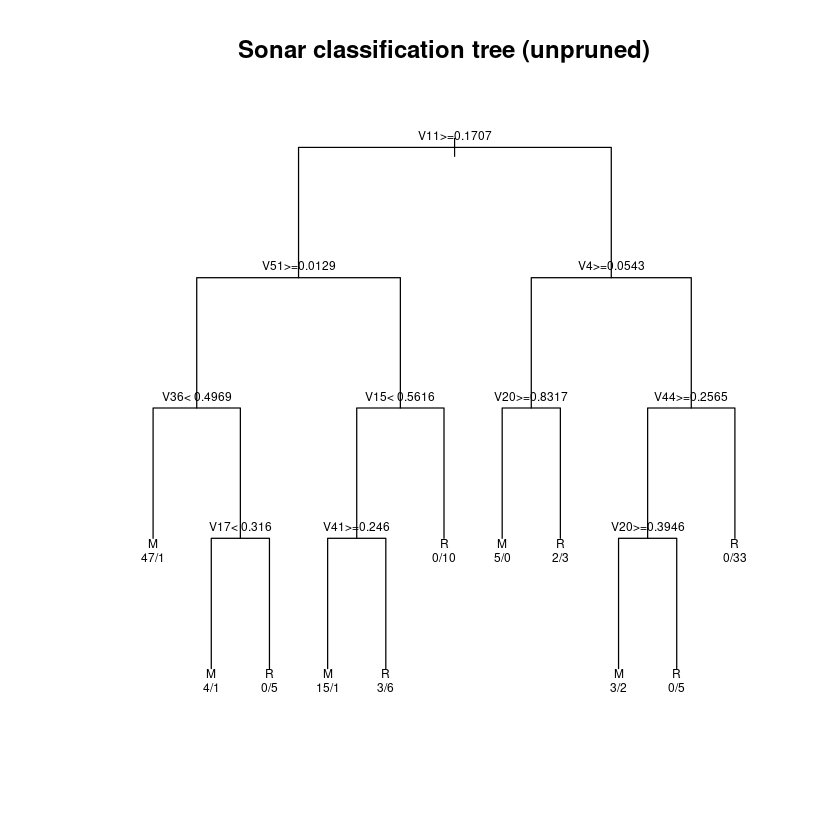

In [144]:

par(xpd = NA)
plot(sonar_tree, uniform = TRUE, margin = 0.05)
text(sonar_tree, use.n = TRUE, cex = 0.6)
title("Sonar classification tree (unpruned)")

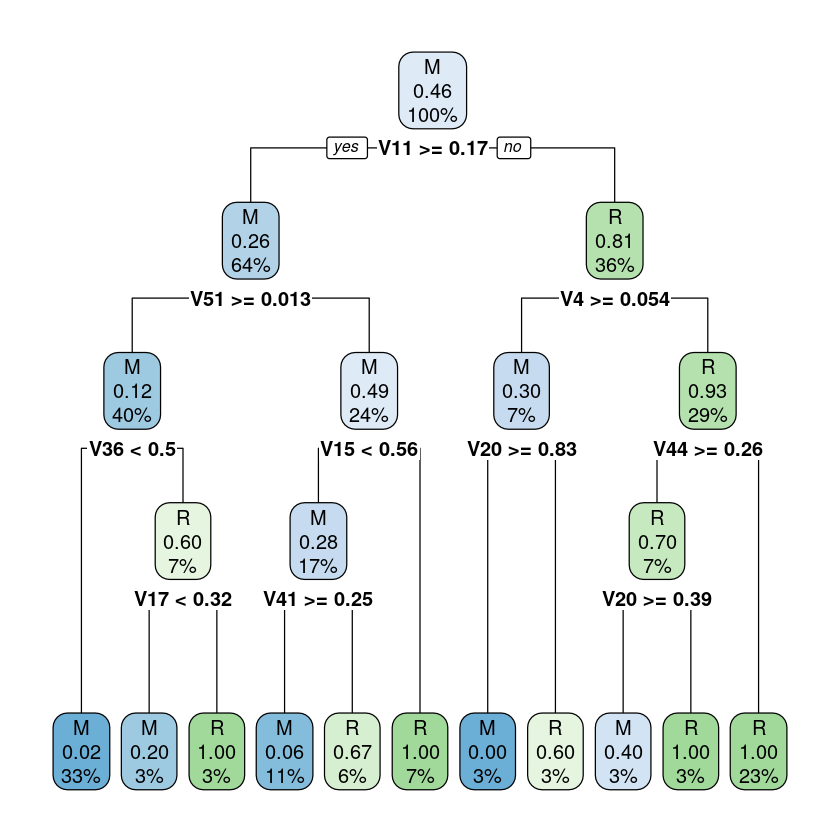

In [145]:
rpart.plot(sonar_tree)

In [146]:
imp_unpruned = sonar_tree$variable.importance
imp_unpruned = sort(imp_unpruned, decreasing = TRUE)

In [147]:
head(imp_unpruned, 10)

V11       V10       V12        V9       V17       V13       V16       V15 
22.107531 12.478509 12.478509 11.608742  9.083429  8.578975  8.484571  8.402888 
      V18       V40 
 8.196363  7.156964

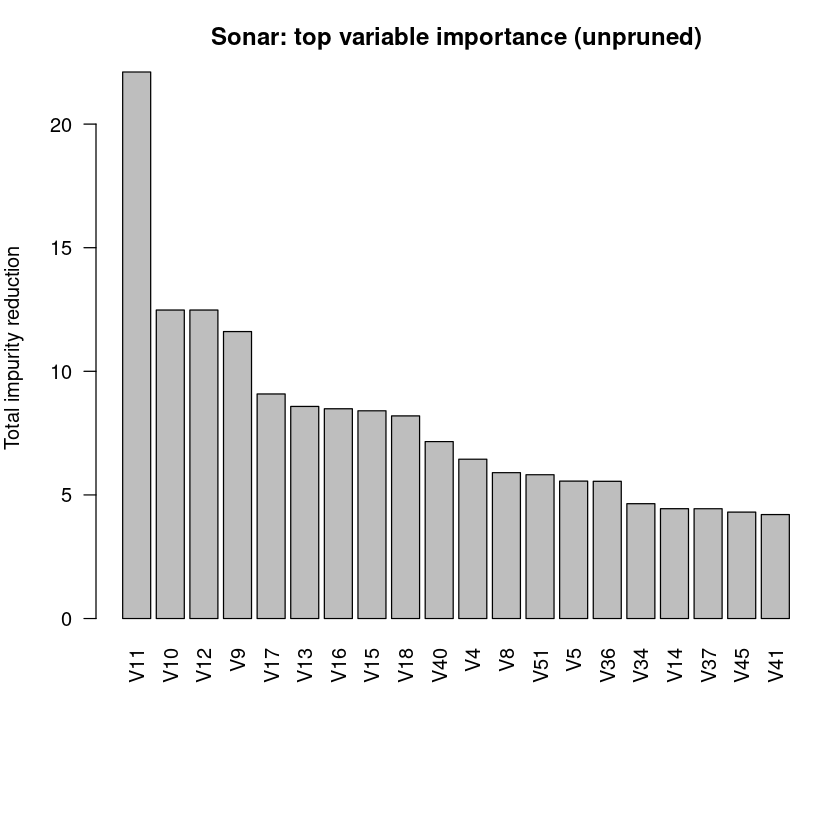

In [148]:
top_k = min(20, length(imp_unpruned))
par(mar = c(9, 4, 3, 1))
barplot(imp_unpruned[1:top_k],
        las = 2,
        main = "Sonar: top variable importance (unpruned)",
        ylab = "Total impurity reduction")

split_vars
V20 V11 V15 V17 V36  V4 V41 V44 V51 
  2   1   1   1   1   1   1   1   1 

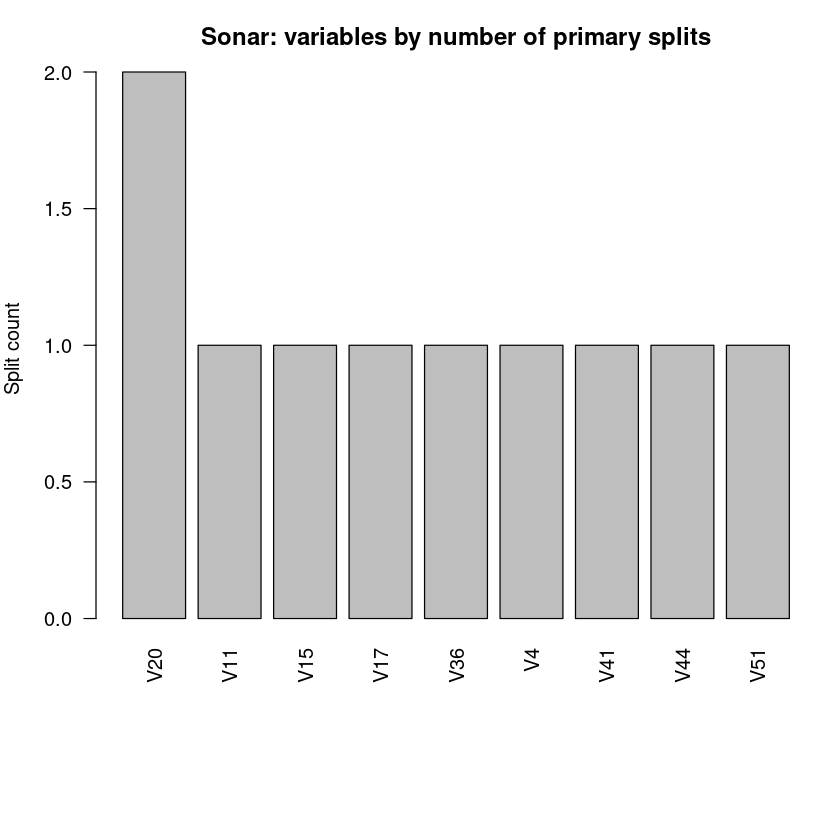

In [149]:
split_vars = as.character(sonar_tree$frame$var)
split_vars = split_vars[split_vars != "<leaf>"]
usage_table = sort(table(split_vars), decreasing = TRUE)

head(usage_table, 10)

par(mar = c(9, 4, 3, 1))
barplot(usage_table[1:min(20, length(usage_table))],
        las = 2,
        main = "Sonar: variables by number of primary splits",
        ylab = "Split count")

[1] 0.03731343


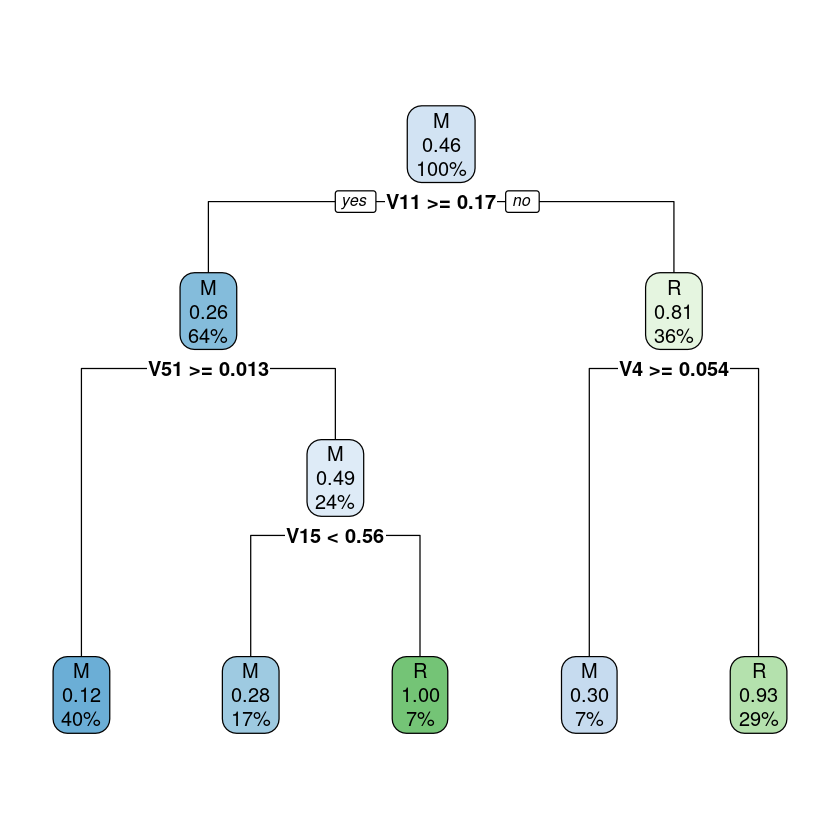

In [157]:
cp_table = sonar_tree$cptable
cp_optimal = cp_table[which.min(cp_table[ , "xerror"]), "CP"]
print(cp_optimal)
sonar_tree_pruned = prune(sonar_tree, cp = 0.05)
rpart.plot(sonar_tree_pruned)

In [158]:
imp_pruned = sonar_tree_pruned$variable.importance
imp_pruned = sort(imp_pruned, decreasing = TRUE)

In [159]:
vars_union = union(names(imp_unpruned)[1:min(15, length(imp_unpruned))],
                   names(imp_pruned)[1:min(15, length(imp_pruned))])


In [160]:

vals_un = imp_unpruned[vars_union]; vals_un[is.na(vals_un)] = 0
vals_pr = imp_pruned[vars_union];   vals_pr[is.na(vals_pr)] = 0


In [161]:
vals_un_scaled = 100 * vals_un / max(vals_un)
vals_pr_scaled = 100 * vals_pr / max(vals_pr)


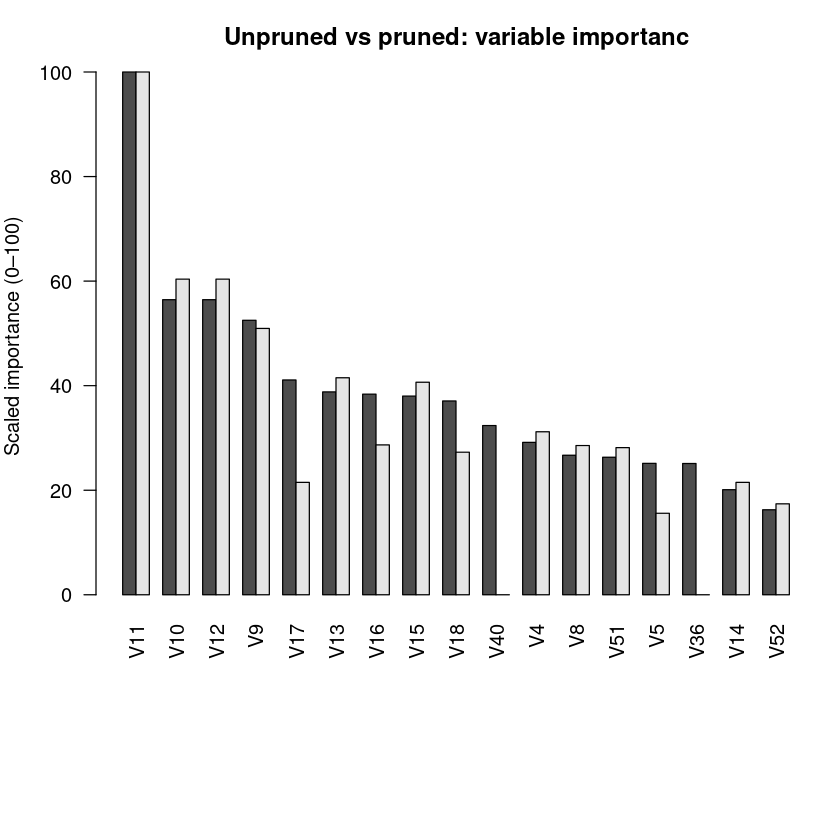

In [163]:

par(mar = c(10, 4, 3, 1))
barplot(rbind(vals_un_scaled, vals_pr_scaled),
        beside = TRUE,
        las = 2,
        names.arg = vars_union,
        ylab = "Scaled importance (0–100)",
        main = "Unpruned vs pruned: variable importanc")


In [164]:
pred_un_te = predict(sonar_tree, newdata = testing_set, type = "class")
pred_pr_te = predict(sonar_tree_pruned, newdata = testing_set, type = "class")
err_un_te  = mean(pred_un_te != testing_set$Class)
err_pr_te  = mean(pred_pr_te != testing_set$Class)

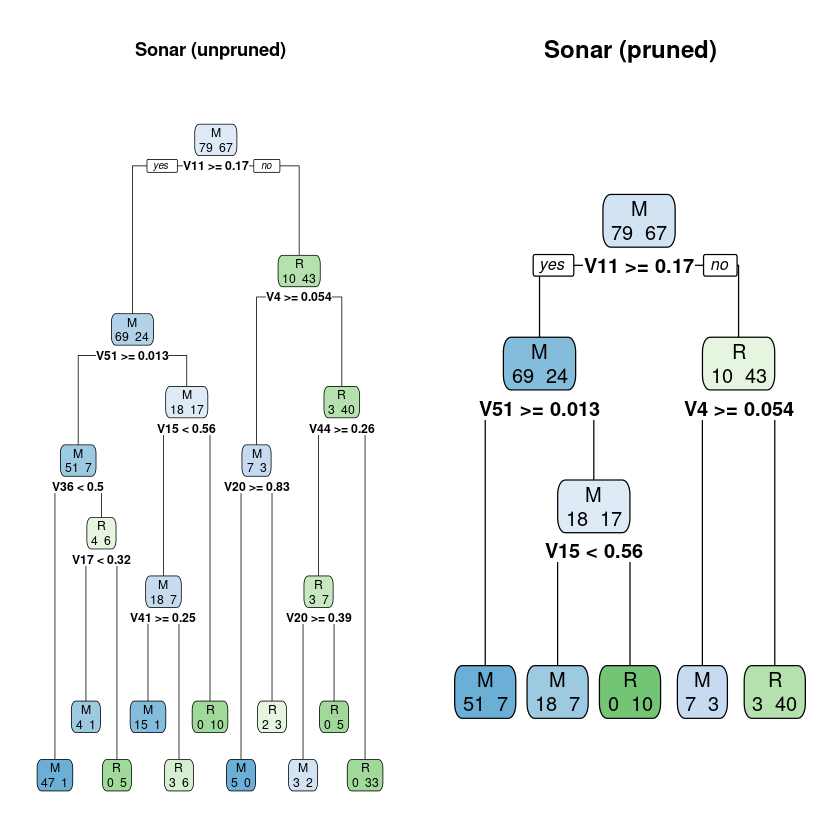

In [165]:
par(mfrow = c(1, 2))
rpart.plot(sonar_tree, main = "Sonar (unpruned)", type = 2, extra = 1, varlen = 0, faclen = 0)
rpart.plot(sonar_tree_pruned, main = "Sonar (pruned)", type = 2, extra = 1, varlen = 0, faclen = 0)
par(mfrow = c(1, 1))



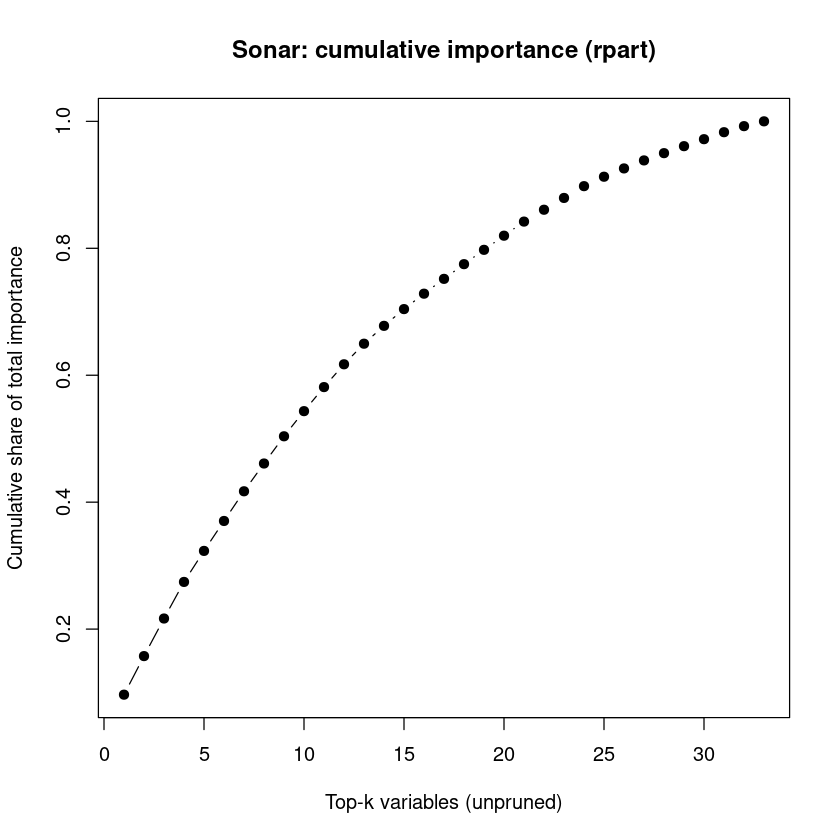

In [133]:
imp_norm = imp_unpruned / sum(imp_unpruned)
cum_share = cumsum(imp_norm)

plot(seq_along(cum_share), cum_share, type = "b", pch = 19,
     xlab = "Top-k variables (unpruned)",
     ylab = "Cumulative share of total importance",
     main = "Sonar: cumulative importance (rpart)")